# Digital House - Data Science a Distancia

## Trabajo Práctico 2

Prepara el dataset original con las características que se presentan en el [valuador de Properati](https://www.properati.com.ar/tools/valuador-propiedades)

### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Mayo 2022</p>


#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
data_url = "../Data/properatti.csv"
data = pd.read_csv(data_url, encoding="utf-8")

---
### Generación del dataset final

#### Eliminamos los valores nulos de la variable Target

In [4]:
data.rename(columns={'property_type' : 'tipo', 'price_aprox_usd' : 'precio','surface_covered_in_m2' : 'sup'}, inplace=True)

In [5]:
#Limpiamos los NaN en el precio
data = data.dropna(axis=0, how='any', subset=['precio', 'sup'])
data_clean = data

#### Seleccionamos solo Capital Federal y Bs.As. zonas Norte, Sur y Oeste

In [6]:
#Seleccionamos solo Capital Federal y Bs.As. zonas Norte, Sur y Oeste
# iterar_state = ['Capital Federal',
#                 'Bs.As. G.B.A. Zona Norte',
#                 'Bs.As. G.B.A. Zona Sur',
#                 'Bs.As. G.B.A. Zona Oeste']

iterar_state = data_clean['state_name'].value_counts().head(6)
iterar_state = iterar_state.index

data_clean['state_name'] = [x if x in iterar_state else np.NaN for x in data_clean['state_name']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['state_name']).copy()

#### Seleccionamos solo Departamento, Casa y PH

In [7]:
#Seleccionamos solo Departamento, Casa y PH
iterar_tipo = data_clean['tipo'].value_counts().head(3)
iterar_tipo = iterar_tipo.index

data_clean['tipo'] = [x if x in iterar_tipo else np.NaN for x in data_clean['tipo']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['tipo']).copy()

In [8]:
data_clean['place_name'].value_counts().head(100)

Córdoba            4719
Mar del Plata      4226
Tigre              2949
Nordelta           2785
Belgrano           2362
                   ... 
Burzaco             155
Valentín Alsina     154
El Palomar          152
Muñiz               151
Ciudadela           148
Name: place_name, Length: 100, dtype: int64

#### Seleccionamos solo Lugares con muchas observaciones

In [9]:
#Seleccionamos solo Lugares con muchas observaciones
iterar_place = data_clean['place_name'].value_counts()[:100]
iterar_place = iterar_place.index

data_clean['place_name'] = [x if x in iterar_place else 'otro' for x in data_clean['place_name']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['place_name']).copy()

#### Eliminamos Outliers para las variables que vamos a correlacionar: 

In [10]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    u"""Solo recibe columnas con valores numericos. 
    Data: dataset a analizar
    Columnas: columnas donde borrar outliers.Deben ser una tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #ajusto el min value 
            # No puede ser negativo.
            # No puede estar fuera del boxplot para outliers
            # Criterio experto se decide dejar desde el 5% hacia adelante en el precio.
            # Además, no consideraremos los que tienen menos de 10m2.
        if i=='precio':
            min_value=max(data[i].quantile(0.05), min_value, 1000)
        else: 
            min_value=max(data[i].quantile(0.05), min_value, 10)
        
        max_value=(min(data[i].quantile(0.85), max_value, 800000))
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [11]:
# serie para determinar observaciones sin outliers para precio en dólares y superficie cubierta
data_clean['tidy1'] = np.NaN

for tipo in iterar_tipo:
    for place in iterar_place:
        # selecciono por lugar y tipo
        mask = np.logical_and(data_clean['place_name']==place, data_clean['tipo']==tipo)
        # calcula outliers y los suprime
        data_ok = borrar_outliers(data_clean[mask], ('precio', 'sup'))
        # determina observaciones válidas
        data_clean.loc[data_ok.index, 'tidy1'] = True

# probablemente esto se pueda hacer con algún método de pandas pero me resulta más simple pensarlo de este modo

In [12]:
# suprimo las observaciones que no me sirven
data_clean = data_clean.dropna(axis=0, how='any', subset=['tidy1'])

---
#### Creacion de nuevas variables con valor predictivo:


##### Analisis para Cantidad de ambientes

In [13]:
def regex_to_values(col, reg, not_match=0) :
    u"""Returns a serie with the result of apply the regular expresion to the column
    the serie have a float value only when regular expression search() method found a match
    
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : not_match if x is np.NaN or x is None else float(x.group(1)))

    return serie

In [14]:
#Buscamos cantidad de ambientes
_pattern = '([1-2][0-9]?)(?= amb)'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_values(data_clean['description'], _express, 1)

data_clean['ambientes'] = work


In [15]:
#realizamos la imputacion
#data_clean['ambientes_final'] = data_clean['rooms']
#mask = data_clean['ambientes_final'].isnull()
#data_clean.loc[mask, 'ambientes_final'] = data_clean.loc[mask, 'ambientes']

mask = data_clean['rooms'].notnull()
data_clean.loc[mask, 'ambientes'] = data_clean.loc[mask, 'rooms']

##### Analisis para Cantidad de baños

In [16]:
_pattern = '([1-2][0-9]?)(?= baño)'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_values(data['description'], _express, 1)

data_clean['baños'] = work


---
##### Nos proponemos encontrar amenities

In [17]:
def regex_to_tags(col, reg, match, not_match = np.NaN) :
    u"""Returns a series with 'match' values result of apply the regular expresion to the column
    the 'match' value will be when the regular expression search() method found a match
    the 'not_match' value will be when the regular expression serach() method did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : match if x is not None else not_match)
   
    return serie

In [18]:
#Buscamos Balcón
_pattern = 'balcon|balcón'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['balcon'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [19]:
#Buscamos Cocheras
_pattern = 'cochera|garage|auto'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['cochera'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [20]:
#Buscamos Parrillas
_pattern = 'parrilla'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['parrilla'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [21]:
#Buscamos Piletas
_pattern = 'piscina|pileta'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['pileta'] = regex_to_tags(data_clean['description'], _express, 1, 0)



In [22]:
#Buscamos Amoblado
_pattern = 'amoblado'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['amoblado'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [23]:
#Buscamos Lavadero
_pattern = 'lavadero'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['lavadero'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [24]:
#Buscamos Patio
_pattern = 'patio'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['patio'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [25]:
#Buscamos Terraza
_pattern = 'terraza'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['terraza'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [26]:
#Buscamos Jardin
_pattern = 'jardin'
_express = re.compile(_pattern, flags = re.IGNORECASE)

data_clean['jardin'] = regex_to_tags(data_clean['description'], _express, 1, 0)


In [27]:
data_clean.reset_index(inplace=True)

In [28]:
data_clean = data_clean.drop(columns=['index', 'Unnamed: 0','operation', 'place_with_parent_names', 
                                      'country_name','geonames_id', 'lat-lon', 'lat', 'lon', 'price', 'currency',
                                        'price_aprox_local_currency','floor', 'price_usd_per_m2', 
                                     'price_per_m2', 'rooms', 'expenses', 'properati_url', 'description', 'title', 'image_thumbnail', 'surface_total_in_m2', 
                                      'tidy1'])

In [29]:
data_clean.columns

Index(['tipo', 'place_name', 'state_name', 'precio', 'sup', 'ambientes',
       'baños', 'balcon', 'cochera', 'parrilla', 'pileta', 'amoblado',
       'lavadero', 'patio', 'terraza', 'jardin'],
      dtype='object')

In [30]:
data_clean = pd.get_dummies(data=data_clean, columns=['tipo', 'place_name','state_name'], drop_first=True)
data_clean.columns

Index(['precio', 'sup', 'ambientes', 'baños', 'balcon', 'cochera', 'parrilla',
       'pileta', 'amoblado', 'lavadero',
       ...
       'place_name_Villa Luro', 'place_name_Villa Luzuriaga',
       'place_name_Villa Pueyrredón', 'place_name_Villa Urquiza',
       'place_name_Villa del Parque', 'state_name_Bs.As. G.B.A. Zona Oeste',
       'state_name_Bs.As. G.B.A. Zona Sur',
       'state_name_Buenos Aires Costa Atlántica', 'state_name_Capital Federal',
       'state_name_Córdoba'],
      dtype='object', length=119)

In [31]:
data_clean['sup2']=data_clean['sup']**2

In [32]:
# data_clean['supxhouse']=data_clean['sup']*data_clean['tipo_house']
# data_clean['supxapartment']=data_clean['sup']*data_clean['tipo_apartment']

amenities= ['balcon', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

for a in amenities:
    cat1='tipo_house'+'x'+a
    data_clean[cat1]=data_clean['tipo_house']*data_clean[a]
    
    cat2='tipo_apartment'+'x'+a
    data_clean[cat2]=data_clean['tipo_apartment']*data_clean[a]

for b in data_clean.columns:
    if b=="precio":
        continue
    cat3='sup'+'x'+b
    data_clean[cat3]=data_clean['sup']*data_clean[b]

C:\Users\jtentor\AppData\Local\Temp/ipykernel_19844/664522142.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_clean[cat3]=data_clean['sup']*data_clean[b]


In [33]:
data_final=data_clean.copy()

In [34]:
data_final.columns

Index(['precio', 'sup', 'ambientes', 'baños', 'balcon', 'cochera', 'parrilla',
       'pileta', 'amoblado', 'lavadero',
       ...
       'supxtipo_housexamoblado', 'supxtipo_apartmentxamoblado',
       'supxtipo_housexlavadero', 'supxtipo_apartmentxlavadero',
       'supxtipo_housexpatio', 'supxtipo_apartmentxpatio',
       'supxtipo_housexterraza', 'supxtipo_apartmentxterraza',
       'supxtipo_housexjardin', 'supxtipo_apartmentxjardin'],
      dtype='object', length=275)

In [35]:
excluir=['precio']
features = data_final.columns.difference(excluir)

In [36]:
scaler = StandardScaler()

data_final[features] = scaler.fit_transform(data_final[features])

In [37]:
data_final

,precio,sup,ambientes,baños,balcon,cochera,parrilla,pileta,amoblado,lavadero,...,supxtipo_housexamoblado,supxtipo_apartmentxamoblado,supxtipo_housexlavadero,supxtipo_apartmentxlavadero,supxtipo_housexpatio,supxtipo_apartmentxpatio,supxtipo_housexterraza,supxtipo_apartmentxterraza,supxtipo_housexjardin,supxtipo_apartmentxjardin
0,62000.0,-0.722666,0.179637,-0.118486,-0.830648,-0.970628,-0.707163,-0.624249,-0.093183,1.458855,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
1,72000.0,-0.507297,0.179637,-0.118486,-0.830648,-0.970628,-0.707163,-0.624249,-0.093183,1.458855,...,-0.01861,-0.085107,-0.402572,1.842816,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
2,64000.0,-0.794456,-0.636088,-0.118486,-0.830648,-0.970628,-0.707163,-0.624249,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
3,130000.0,-0.177065,-0.636088,-0.118486,-0.830648,-0.970628,-0.707163,-0.624249,-0.093183,1.458855,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
4,138000.0,-0.722666,-0.636088,-0.118486,-0.830648,-0.970628,-0.707163,1.601925,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47507,128000.0,-0.794456,-0.636088,-0.118486,-0.830648,1.030261,1.414102,1.601925,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,1.145273,-0.193117,-0.169698
47508,165000.0,-0.737024,-0.636088,-0.118486,1.203879,-0.970628,1.414102,-0.624249,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,-0.193117,-0.169698
47509,498000.0,3.871874,-0.636088,-0.118486,-0.830648,1.030261,1.414102,1.601925,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,-0.415710,8.659879,-0.169698
47510,131500.0,-0.737024,-0.636088,-0.118486,1.203879,1.030261,1.414102,-0.624249,-0.093183,-0.685469,...,-0.01861,-0.085107,-0.402572,-0.369594,-0.272725,-0.217469,-0.234073,1.323671,-0.193117,-0.169698


In [38]:
#--------------------------------------------------------------#

In [39]:
#divido en data train y data test

In [40]:
data_train, data_test = train_test_split(data_final, test_size=0.35, random_state =300)

In [41]:
target =data_train.precio

X = data_train[features]
y = target

In [42]:
# model = linear_model.Lasso(alpha=1, normalize=True)
# model = linear_model.ElasticNetCV(l1_ratio=[1], alphas=[0.000001], normalize=False, cv=3, max_iter=2000)
model = linear_model.LinearRegression()

#Probe un monton de combinaciones. No encontre overfit en ninguna. Vamos directamente con LinearRegression

In [43]:
#No entiendo porque, pero si llamo a model.fit varias veces, funciona. Si lo uso una sola vez no funciona (overfitea a morir)

In [44]:
model.fit(X, y)

LinearRegression()

In [45]:
model.fit(X, y)

LinearRegression()

In [46]:
model.fit(X, y)

LinearRegression()

In [47]:
# print(model.alpha_)
# print(model.l1_ratio_)

In [48]:
# for f in range(len(features)):
#     space=len(features[f])
#     print(f'feature: {features[f]}  {" "*(40-space)}beta: {model.coef_[f]}')

In [49]:
##Checkeo de modelo

In [50]:
n_train=data_train.shape[0]
r2_train=model.score(X=data_train[features], y = data_train.precio)
r2_adj_train = 1-(1-r2_train)*((n_train-1)/(n_train-len(features)-1))
precio_est_train=model.predict(data_train[features])
RMSE_train= np.sqrt(mean_squared_error(y_true=data_train['precio'], y_pred=precio_est_train))
print(f'r2_train: {r2_train} \nr2_adj_train: {r2_adj_train} \nRMSE: {RMSE_train} ')

r2_train: 0.809394857188605 
r2_adj_train: 0.8076885217382074 
RMSE: 53704.27039513527 


In [51]:
n_test=data_test.shape[0]
r2_test=model.score(X=data_test[features], y = data_test.precio)
r2_adj_test = 1-(1-r2_test)*((n_test-1)/(n_test-len(features)-1))
precio_est_test=model.predict(data_test[features])
RMSE_test= np.sqrt(mean_squared_error(y_true=data_test['precio'], y_pred=precio_est_test))
print(f'r2_test: {r2_test} \nr2_adj_test: {r2_adj_test} \nRMSE: {RMSE_test} ')

r2_test: 0.8152695646617616 
r2_adj_test: 0.8121747227612617 
RMSE: 54095.92495615072 


In [52]:
from statsmodels.regression import linear_model as sm_linear_model
X = data_test[features]
y = data_test['precio']
model_sm = sm_linear_model.OLS(y, X).fit()
# model_sm.summary()

In [53]:
model_sm.pvalues[model_sm.pvalues < 0.05].index

Index(['place_name_Boedo', 'place_name_Ciudadela', 'place_name_Palermo Chico',
       'place_name_Puerto Madero', 'place_name_San Cristobal', 'sup2',
       'supxambientes', 'supxplace_name_Boedo', 'supxplace_name_Ciudadela',
       'supxplace_name_Córdoba', 'supxplace_name_Escobar',
       'supxplace_name_Ituzaingó', 'supxplace_name_Lomas de Zamora',
       'supxplace_name_Mataderos', 'supxplace_name_Parque Patricios',
       'supxplace_name_Pilar', 'supxplace_name_Quilmes',
       'supxplace_name_San Cristobal', 'supxplace_name_San Martín',
       'supxplace_name_San Miguel', 'supxplace_name_Villa Ballester',
       'supxstate_name_Bs.As. G.B.A. Zona Oeste',
       'supxstate_name_Bs.As. G.B.A. Zona Sur', 'supxstate_name_Córdoba',
       'supxsup', 'supxsup2', 'supxtipo_apartment'],
      dtype='object')

In [54]:
import statsmodels.api as sm

def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - bserverd features
    * ytest - observed values
    """

    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x=ypred, y=ytest, lowess=True, line_kws={'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
#     plt.figure(figsize=(16, 8))
#     sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
#     plt.title('Scale Location', fontdict = {'fontsize': 18})
#     plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
#     plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
#     plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top=1.5, wspace=2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return

C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:693: RuntimeWarning: divide by zero encountered in true_divide
  return self.resid / sigma / np.sqrt(1 - hii)


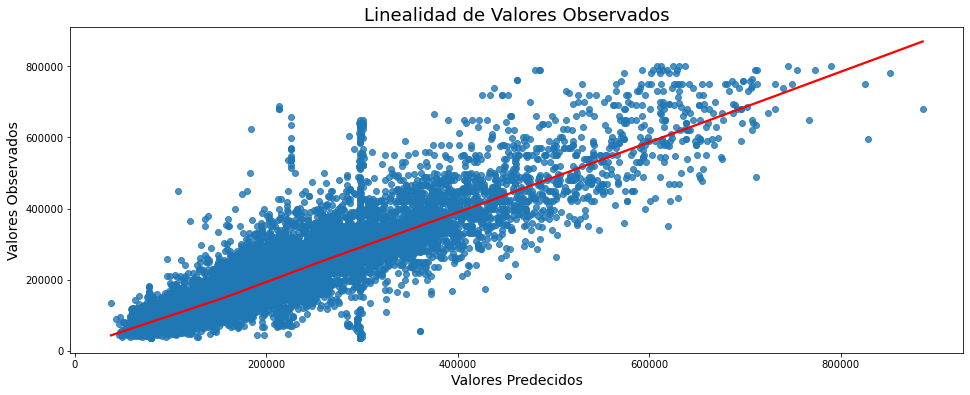

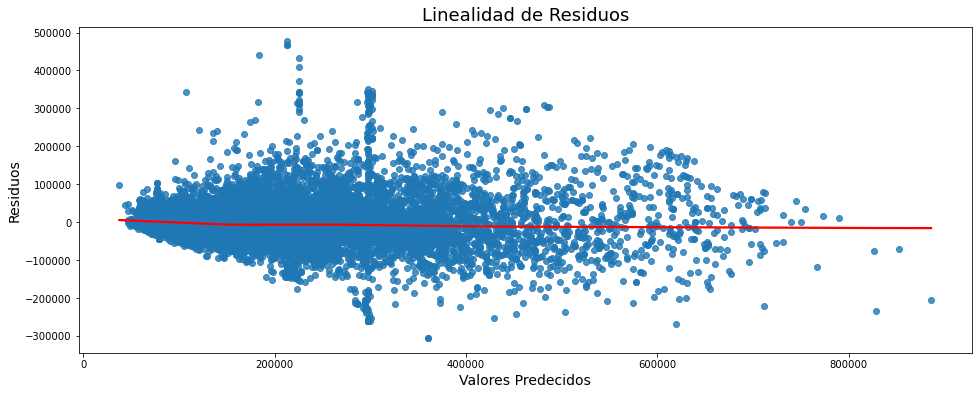

C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


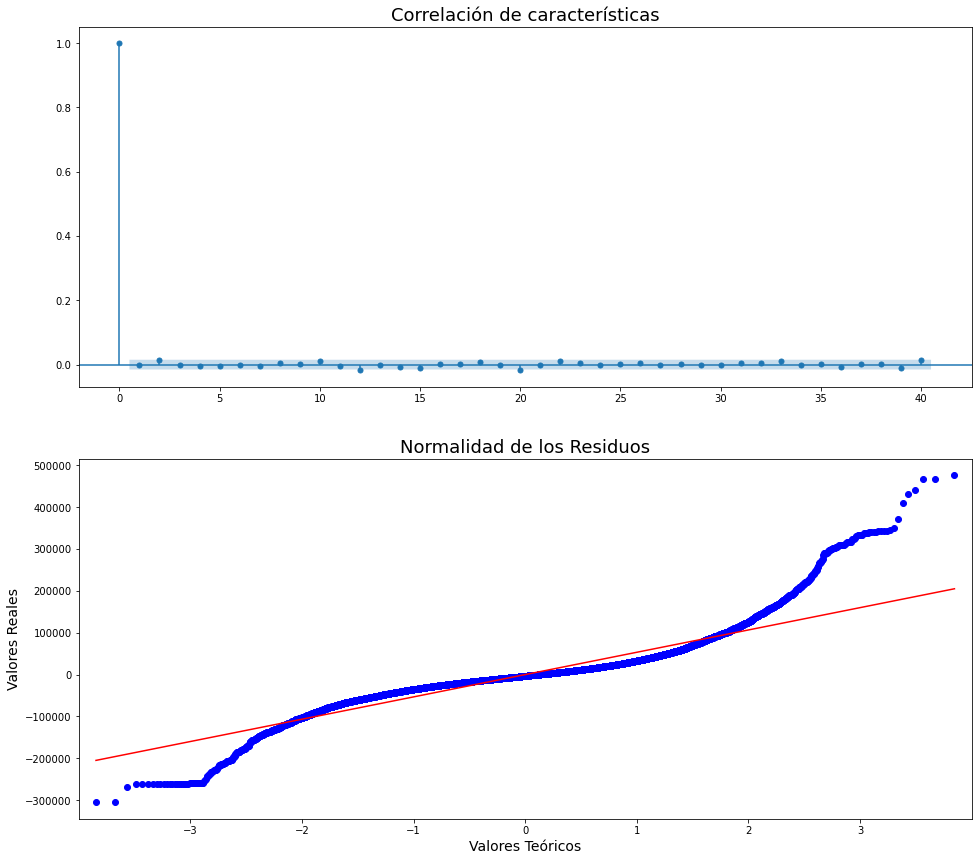

In [55]:
gauss_markov_test(data_test[features], data_test['precio'])
